In [1]:
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date_of_data = (session
             .query(Measurement.date)
             .order_by(Measurement.date.desc())
             .first())
print(last_date_of_data)

('2017-08-23',)


In [9]:
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(365)
print(last_year)

2016-08-23


In [10]:
# Perform a query to retrieve the data and precipitation scores
prcp_query = (session
              .query(Measurement.date, Measurement.prcp)
              .filter(Measurement.date>dt.datetime(2016, 8, 23))
              .all())
#print(prcp_query)

In [11]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_query)
prcp_df.set_index("date", inplace=True)
prcp_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [12]:
# Sort the dataframe by date
sorted_df = prcp_df.sort_values("date", ascending=True).dropna()
sorted_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45


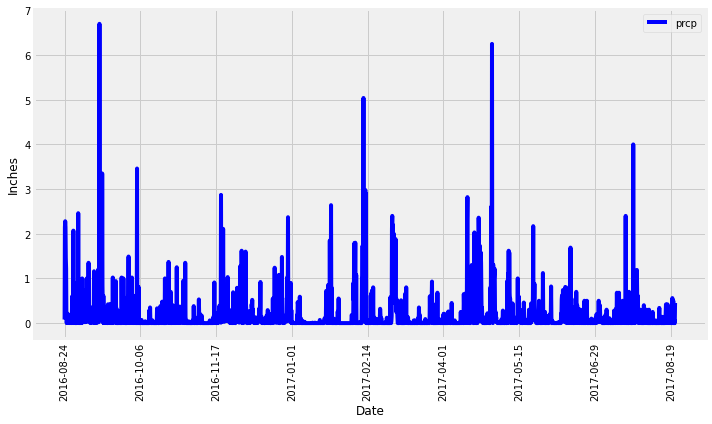

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
sorted_df.plot(color="blue", figsize=(10, 6), rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend()
plt.tight_layout()
plt.savefig("Output/Precipitation.png")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
stations_number=session.query(Station).count()
stations_number

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations_query = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
list(most_active_stations_query)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_query = (
    session.query(
        Measurement.station,
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == "USC00519281")
    .all()
)
print(temp_query)

[('USC00519281', 54.0, 85.0, 71.66378066378067)]


In [18]:
df=pd.DataFrame(temp_query, columns=["Station ID", "Lowest Temp", "Highest Temp", "Avg Temp"])
df

,Station ID,Lowest Temp,Highest Temp,Avg Temp
0,USC00519281,54.0,85.0,71.663781


In [19]:
# Choose the station with the highest number of temperature observations.
high_temp_station_query=(session
                         .query(Measurement.station, func
                         .count(Measurement.station))
                         .group_by(Measurement.station)
                         .order_by(func.count(Measurement.station).desc())
                         .first())
print(high_temp_station_query)

('USC00519281', 2772)


In [20]:
# Query the last 12 months of temperature observation data for this station
station_temp_obsrv=(session
                    .query(Measurement.date, Measurement.tobs)
                    .filter(Measurement.station == "USC00519281")
                    .filter(Measurement.date >= last_year)
                    .all()
                    )
# list(station_temp_obsrv )

In [21]:
station_temp_obsrv_df=pd.DataFrame(station_temp_obsrv)
station_temp_obsrv_df.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


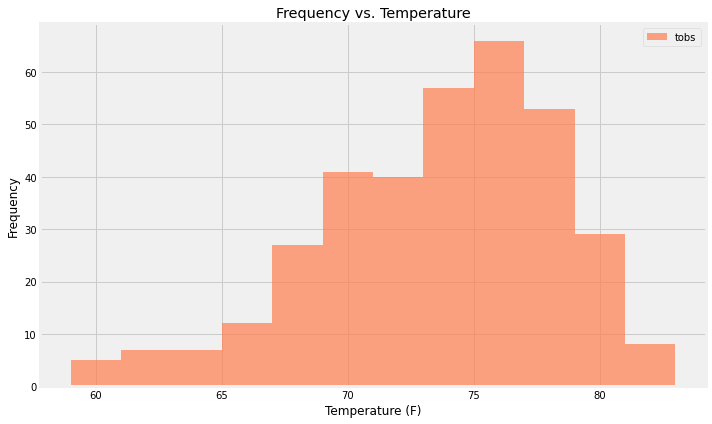

In [37]:
#plot the results as a histogram
station_temp_obsrv_df.hist(bins=12, label="tobs", alpha=0.7, color="coral", figsize=(10,6) )
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Frequency vs. Temperature")
plt.legend()
plt.tight_layout()
plt.savefig("Output/temp_hist.png")
plt.show()

## Bonus Challenge Assignment

# Temperature Analysis II

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return (
        session
        .query(
            func.min(Measurement.tobs), 
            func.avg(Measurement.tobs), 
            func.max(Measurement.tobs)
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2017-08-10', '2017-08-20')
my_trip_df = pd.DataFrame(my_trip, columns=['tmin', 'tavg', 'tmax'])
my_trip_df

,tmin,tavg,tmax
0,70.0,78.422222,85.0


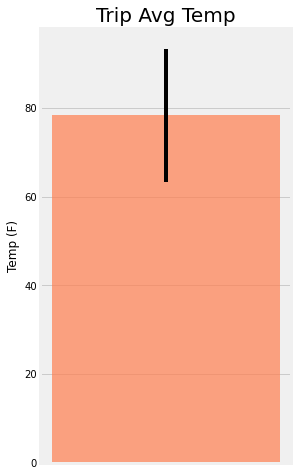

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.0))
xvalue = 1
yvalue= my_trip_df["tavg"]
yerr = my_trip_df["tmax"]-my_trip_df["tmin"]

bar = ax.bar(xvalue, yvalue, alpha=0.7, color='coral', yerr=yerr)
ax.set(xticks=range(xvalue), xticklabels="a")
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.savefig("Output/trip_avg_temp.png")
plt.show()

# Daily Rainfall Average

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [
        func.min(Measurement.tobs), 
        func.avg(Measurement.tobs), 
        func.max(Measurement.tobs)
    ]
    return (
        session
        .query(*sel)
        .filter(func.strftime("%m-%d", Measurement.date) == date)
        .all()
    )
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [38]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "2017-08-10"
end_date = "2017-08-20"
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date)
# Stip off the year and save a list of %m-%d strings
trip_days = trip_dates.strftime("%m-%d")
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_days:
    normals.append(*daily_normals(date))
list(normals)


[(65.0, 76.42, 83.0),
 (67.0, 75.98113207547169, 82.0),
 (67.0, 76.52727272727273, 83.0),
 (71.0, 76.98245614035088, 84.0),
 (71.0, 76.77777777777777, 82.0),
 (69.0, 76.47169811320755, 83.0),
 (69.0, 76.08, 83.0),
 (69.0, 76.125, 83.0),
 (70.0, 76.92307692307692, 84.0),
 (69.0, 75.94642857142857, 85.0),
 (68.0, 76.45283018867924, 82.0)]

In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, columns=["tmin", "tavg", "tmax"])
trip_df["Date"] = trip_dates
trip_df.set_index(["Date"], inplace=True)
trip_df

,tmin,tavg,tmax
Date,,,
2017-08-10,65.0,76.420000,83.0
2017-08-11,67.0,75.981132,82.0
2017-08-12,67.0,76.527273,83.0
2017-08-13,71.0,76.982456,84.0
2017-08-14,71.0,76.777778,82.0
2017-08-15,69.0,76.471698,83.0
2017-08-16,69.0,76.080000,83.0
2017-08-17,69.0,76.125000,83.0
2017-08-18,70.0,76.923077,84.0


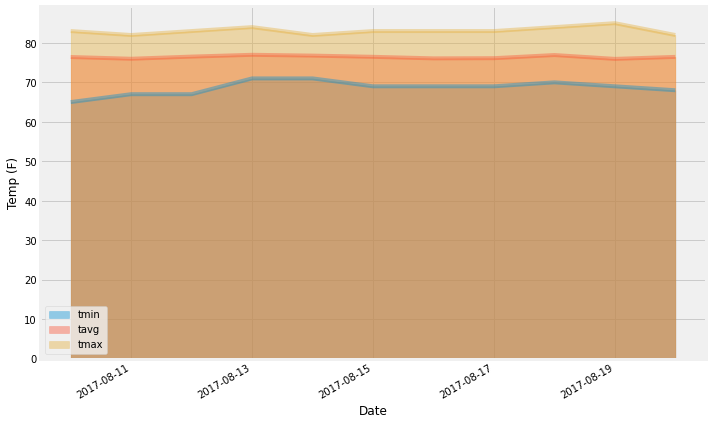

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot(kind="area", stacked=False, x_compat=True, figsize=(10,6), alpha=0.4)
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig("Output/daily_normals.png")
plt.show()

# Temperature Analysis I

In [47]:
# Using the inspector to print the column names within the table and its types
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [48]:
from sqlalchemy import extract  
from scipy import stats
from numpy import mean

In [49]:
# Filter for tempretures in June and December
june_query = session.query(Measurement).\
    filter(extract('month', Measurement.date)==6)

dec_query = session.query(Measurement).\
    filter(extract('month', Measurement.date)==12)

In [50]:
print(june_query.statement)

SELECT measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs 
FROM measurement 
WHERE EXTRACT(month FROM measurement.date) = :param_1


In [51]:
june_df = pd.read_sql_query(june_query.statement, session.get_bind())
june_df.head()

,id,station,date,prcp,tobs
0,134,USC00519397,2010-06-01,0.00,78.0
1,135,USC00519397,2010-06-02,0.01,76.0
2,136,USC00519397,2010-06-03,0.00,78.0
3,137,USC00519397,2010-06-04,0.00,76.0
4,138,USC00519397,2010-06-05,0.00,77.0


In [52]:
dec_df = pd.read_sql_query(dec_query.statement, session.get_bind())
dec_df.head()

,id,station,date,prcp,tobs
0,306,USC00519397,2010-12-01,0.04,76.0
1,307,USC00519397,2010-12-03,0.00,74.0
2,308,USC00519397,2010-12-04,0.00,74.0
3,309,USC00519397,2010-12-06,0.00,64.0
4,310,USC00519397,2010-12-07,0.00,64.0


In [53]:
# Filter out null values from lists
june_list = []
for Measurement in june_query:
    if type(Measurement.tobs) == float:
        june_list.append(Measurement.tobs)
        
dec_list = []
for Measurement in dec_query:
    if type(Measurement.tobs) == float:
        dec_list.append(Measurement.tobs)          

In [54]:
# Average temp for June
mean(june_list)

74.94411764705882

In [55]:
# Average temp for December
mean(dec_list)

71.04152933421226

In [56]:
# Unpaired (independent) t-test
stats.ttest_ind(dec_list, june_list)

Ttest_indResult(statistic=-31.60372399000329, pvalue=3.9025129038616655e-191)

In [57]:
#stats.ttest_rel(dec_list, june_list)